In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import time

In [3]:
base_path_train = "/kaggle/input/naturalist/inaturalist_12K/train" 
input_shape = (224,224)
id2label = {}
label2id = {}
label_list = []
X = []
y = []
for id,label in enumerate(os.listdir(base_path_train)):
    # if label[0]==".":
    #     continue
    id2label[id] = label
    label2id[label] = id
    label_list.append(label)
    label_path = os.path.join(base_path_train,label)
    for img_path in os.listdir(label_path):
        # if img_path == ".DS_Store":
        #     continue
        img = np.array(Image.open(os.path.join(label_path,img_path)))
        img.resize((*input_shape,3))
        X.append(img)
        y.append(id)
    print(f"id:{id}, Label: {label} done")
X = np.array(X).transpose(0, 3, 1, 2)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)
print(X.shape)
print(y.shape)

id:0, Label: Reptilia done
id:1, Label: Animalia done
id:2, Label: Arachnida done
id:3, Label: Amphibia done
id:4, Label: Aves done
id:5, Label: Mollusca done
id:6, Label: Fungi done
id:7, Label: Insecta done
id:8, Label: Plantae done
id:9, Label: Mammalia done
torch.Size([9999, 3, 224, 224])
torch.Size([9999])


In [4]:
base_path_test = "/kaggle/input/naturalist/inaturalist_12K/val" 
input_shape = (224,224)
X_test = []
y_test = []
for id,label in enumerate(os.listdir(base_path_test)):
    # if label[0]==".":
    #     continue
    label_path = os.path.join(base_path_test,label)
    for img_path in os.listdir(label_path):
        # if img_path == ".DS_Store":
        #     continue
        img = np.array(Image.open(os.path.join(label_path,img_path)))
        img.resize((*input_shape,3))
        X_test.append(img)
        y_test.append(id)
    print(f"Test data id:{id}, Label: {label} done")
X_test = np.array(X_test).transpose(0, 3, 1, 2)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)
print(X_test.shape)
print(y_test.shape)

Test data id:0, Label: Reptilia done
Test data id:1, Label: Animalia done
Test data id:2, Label: Arachnida done
Test data id:3, Label: Amphibia done
Test data id:4, Label: Aves done
Test data id:5, Label: Mollusca done
Test data id:6, Label: Fungi done
Test data id:7, Label: Insecta done
Test data id:8, Label: Plantae done
Test data id:9, Label: Mammalia done
torch.Size([2000, 3, 224, 224])
torch.Size([2000])


In [5]:
print(id2label)
print(label2id)
print(label_list)

{0: 'Reptilia', 1: 'Animalia', 2: 'Arachnida', 3: 'Amphibia', 4: 'Aves', 5: 'Mollusca', 6: 'Fungi', 7: 'Insecta', 8: 'Plantae', 9: 'Mammalia'}
{'Reptilia': 0, 'Animalia': 1, 'Arachnida': 2, 'Amphibia': 3, 'Aves': 4, 'Mollusca': 5, 'Fungi': 6, 'Insecta': 7, 'Plantae': 8, 'Mammalia': 9}
['Reptilia', 'Animalia', 'Arachnida', 'Amphibia', 'Aves', 'Mollusca', 'Fungi', 'Insecta', 'Plantae', 'Mammalia']


## Part-A

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary

In [7]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=42)
#Getting (X,y) pairs
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

In [65]:
class customCNN(nn.Module):
    def __init__(self,m=16,k=3,n=256,m_factor=2,n_conv=5,activation_func="ReLU",batch_norm=True,dropout=0.5):
        super().__init__()
        self.k = k # size of filters (kxk)
        self.n = n # no.of neurons in the dense layer
        self.m = m # no. of filters
        self.m_fac = m_factor # filter multiplier
        self.conv_layers = nn.ModuleList()
        self.batch_norm = batch_norm
        self.bn_layers = nn.ModuleList()
        self.dropout = nn.Dropout(dropout)
        self.n_conv = n_conv
        m = self.m
        for i in range(self.n_conv):
            if i==0:
                self.conv_layers.append(nn.Conv2d(3,int(m),self.k))
                self.bn_layers.append(nn.BatchNorm2d(int(m)))
            else:
                if m*self.m_fac>=1:
                    self.conv_layers.append(nn.Conv2d(int(m),int(m*self.m_fac),self.k))
                    self.bn_layers.append(nn.BatchNorm2d(int(m*self.m_fac)))
                    m = m*self.m_fac
                else:
                    self.m_fac = 1
                    self.conv_layers.append(nn.Conv2d(int(m),int(m*self.m_fac),self.k))
                    self.bn_layers.append(nn.BatchNorm2d(int(m*self.m_fac)))
                    m = m*self.m_fac
            
        self.maxpool = nn.MaxPool2d(2,2)
        self.fc1 = nn.LazyLinear(self.n)
        self.fc2 = nn.Linear(self.n, 10)
        activations = {
            "mish": nn.Mish(),
            "gelu": nn.GELU(),
            "silu": nn.SiLU(),
            "relu": nn.ReLU()
        }
        self.activation = activations.get(activation_func.lower(), nn.ReLU())
    def forward(self,x):
        for i in range(self.n_conv):
            x = self.conv_layers[i](x)
            if self.batch_norm:
                x = self.bn_layers[i](x)
            x = self.activation(x)
            x = self.maxpool(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.activation(x)
        x = self.fc2(x)
        # output = F.softmax(x,dim=1)
        return x

In [72]:
def data_loading(data,train=True,batch_size = 64):
    data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=train)
    return data_loader

In [73]:
def train(train_loader,val_loader,n_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(n_epochs):
        start_time = time.time()
    
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
    
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
    
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
    
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
    
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
    
        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
    
        end_time = time.time()
        epoch_time = end_time - start_time
    
        print(f"Epoch {epoch+1} | Time: {epoch_time:.2f}s | "
              f"Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.2f}%")
    
    return train_losses,train_accuracies,val_losses,val_accuracies

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = customCNN().to(device)

train_loader = data_loading(train_data,train=True,batch_size=batch_size)
val_loader = data_loading(val_data,train=False,batch_size=batch_size)
test_loader = data_loading(test_data,train=False,batch_size=batch_size)

train(train_loader,val_loader)

Epoch 1 | Time: 16.54s | Train Loss: 3.750, Train Acc: 10.04% | Val Loss: 2.303, Val Acc: 10.26%
Epoch 2 | Time: 16.40s | Train Loss: 2.304, Train Acc: 10.14% | Val Loss: 2.303, Val Acc: 10.24%
Epoch 3 | Time: 16.63s | Train Loss: 2.304, Train Acc: 9.54% | Val Loss: 2.303, Val Acc: 10.26%
Epoch 4 | Time: 16.42s | Train Loss: 2.304, Train Acc: 10.18% | Val Loss: 2.303, Val Acc: 10.24%
Epoch 5 | Time: 16.73s | Train Loss: 2.304, Train Acc: 9.54% | Val Loss: 2.303, Val Acc: 10.26%
Epoch 6 | Time: 16.41s | Train Loss: 2.304, Train Acc: 9.89% | Val Loss: 2.303, Val Acc: 10.26%
Epoch 7 | Time: 16.57s | Train Loss: 2.304, Train Acc: 9.40% | Val Loss: 2.303, Val Acc: 10.26%
Epoch 8 | Time: 16.21s | Train Loss: 2.304, Train Acc: 9.86% | Val Loss: 2.303, Val Acc: 10.24%
Epoch 9 | Time: 16.60s | Train Loss: 2.304, Train Acc: 10.10% | Val Loss: 2.303, Val Acc: 10.26%
Epoch 10 | Time: 16.41s | Train Loss: 2.304, Train Acc: 9.29% | Val Loss: 2.303, Val Acc: 9.98%


([3.7503523006439208,
  2.3038507957458494,
  2.3037771911621094,
  2.303962200164795,
  2.303579788208008,
  2.3037009353637696,
  2.3036321392059325,
  2.3038600234985354,
  2.3038078842163086,
  2.303827175140381],
 [10.038754844355545,
  10.13876734591824,
  9.538692336542068,
  10.176272034004251,
  9.538692336542068,
  9.888736092011502,
  9.401175146893362,
  9.863732966620828,
  10.10126265783223,
  9.288661082635329],
 [2.302820556640625,
  2.3026637001037598,
  2.3028017768859863,
  2.30280380821228,
  2.3025919284820557,
  2.3026492614746092,
  2.3027170066833498,
  2.3027200660705565,
  2.302551233291626,
  2.302792726516724],
 [10.263782972871608,
  10.238779847480934,
  10.263782972871608,
  10.238779847480934,
  10.263782972871608,
  10.263782972871608,
  10.263782972871608,
  10.238779847480934,
  10.263782972871608,
  9.97624703087886])

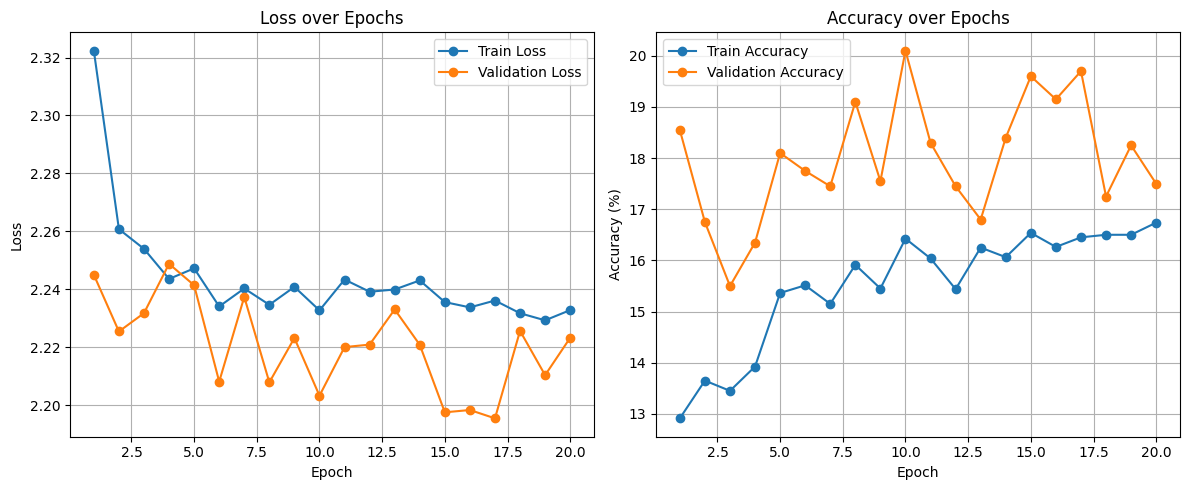

In [68]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()